### _Part-2 Solving Complex Environments with A2C model_

In [1]:
# Imports

import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
import numpy as np
import pickle
import math
import gymnasium as gym
import matplotlib.pyplot as plt

In [2]:
# plot total reward per episode

def total_reward_per_episode(total_reward):
    plt.figure()
    plt.plot(total_reward)
    plt.title('Total Reward per Episode')
    plt.xlabel('episode')
    plt.ylabel('reward')
    plt.grid()
    plt.show()

### _Complex Environment - 1 (Bi-Pedal Walker)_

In [106]:
class A2CNetwork(keras.models.Model):
    
    def __init__(self):
        
        super().__init__()
        
        # define layers in actor-critic networks
        self.dense_relu = keras.layers.Dense(64, activation = "relu", input_shape = (24,), name = "first-layer")
        self.dense_softplus = keras.layers.Dense(4, activation = "softplus", name = "softplus layer")
        self.tanh = keras.layers.Dense(4, activation = "tanh", name = "tanh-layer")
        self.linear = keras.layers.Dense(1, activation = None, name = "linear-layer")
                                        
    def call(self, inputs):
        
        # define forward pass
        dense_out = self.dense_relu(inputs) 
        mean = self.tanh(dense_out)  
        var = self.dense_softplus(dense_out) 
        value = self.linear(dense_out)
        
        # return mean, variance and state value for the input state
        return mean, var, value  

In [107]:
class A2C_BiPedal:
    
    def __init__(self, environment, discount_factor):
        
        self.action_space = 4
        self.discount_factor = discount_factor
        self.model = A2CNetwork()
        
        # initialize optimizer 
        self.optimizer = keras.optimizers.Adam()
                                             
    def step(self, state, training_):
        
        # pass the state to actor to obtain actions
        state = tf.expand_dims(state, axis = 0)
        mean, var, _ = self.model(state, training = training_)

        # return std.deviation and mean of the continuous action distribution
        sigma = tf.sqrt(var)        
        action = np.random.normal(mean.numpy(), sigma.numpy())
        
        return np.clip(action, -1, 1)
    
    # define custom-loss
    def custom_loss(self,mean, var, action):
        a = -(tf.square(mean - action)/ (2*tf.clip_by_value(var, clip_value_min = 1e-3, clip_value_max=1e-1)))
        b = - tf.math.log(tf.sqrt(2*np.math.pi*var))
        
        return a+b
        
    def train(self, buffer):
        
        gradients_list = list()
        
        
        for state, action, reward, next_state, terminated in buffer[::-1]:
            
            with tf.GradientTape() as tape:
                
                state = tf.expand_dims(state, axis = 0)
                mean, var, state_value = self.model(state, training = True)
                
                
                if terminated:
                    state_value = tf.Variable([[0]], dtype = tf.float32)
                    
                
                R = reward + (self.discount_factor*state_value)

                # compute loss
                temp = self.custom_loss(mean, var, action)
                actor_loss = -tf.reduce_mean(temp*(R - tf.stop_gradient(state_value)))
                critic_loss = tf.reduce_mean(tf.square(R - tf.stop_gradient(state_value)))
                
                # compute entropy-loss
                entropy_loss = (1e-4)*tf.reduce_mean(-(tf.math.log(2*np.math.pi*var)+1)/2)
                
                total_loss = actor_loss + critic_loss + entropy_loss
            
            # compute gradients and append to the list
            gradients = tape.gradient(total_loss, self.model.trainable_weights)
            gradients_list.append(gradients)
        
        res = gradients_list[0][:-2]

        for element in gradients_list[1:]:
            for index,grad in enumerate(element[:-2]):
                res[index] += grad
         
        # apply the gradients to the model variables
        self.optimizer.apply_gradients(zip(res, self.model.trainable_weights))

In [108]:
# initialize the BipedalWalker environment
environment2 = gym.make("BipedalWalker-v3", hardcore = False)

# initialize the A2C agent
agent2 = A2C_BiPedal(environment2, discount_factor = 0.99)

In [109]:
# set-up
episodes = 300
reward_historyt2 = list()
max_timesteps = 1600
buffer = list()

# training
for episode in range(episodes):
    
    state = environment2.reset()[0]
    total_reward = 0
    step_count = 0
    
    while step_count <= max_timesteps:
        
        action = agent2.step(state, True)
        next_state, reward, terminated, truncated, info = environment2.step(tf.squeeze(action))
        buffer.append([state, action, reward, next_state, terminated])
        
        total_reward += reward
        state = next_state
        step_count+=1

        if terminated: break
    
    agent2.train(buffer)
    
    reward_historyt2.append(total_reward)
    buffer.clear()

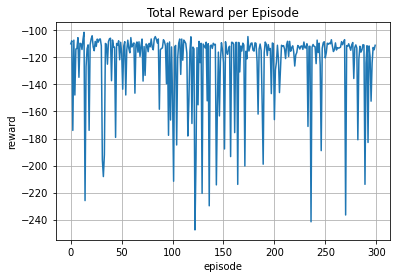

In [110]:
total_reward_per_episode(reward_historyt2)

In [111]:
# set-up
episodes = 10
reward_historye2 = list()
max_timesteps = 20

# evaluation
for episode in range(episodes):
    state = environment2.reset()[0]
    total_reward = 0
    step_count = 0

    while step_count <= max_timesteps:
        
        action = agent2.step(state, False)
        next_state, reward, terminated, truncated, info = environment2.step(tf.squeeze(action))
        environment2.render()
        
        total_reward += reward
        step_count+=1

        if terminated: break
        
        state = next_state
    reward_historye2.append(total_reward)

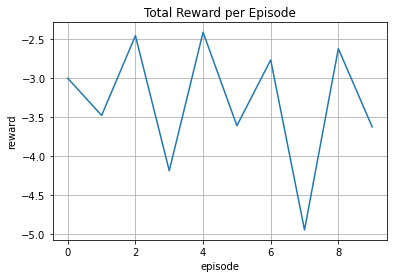

In [112]:
total_reward_per_episode(reward_historye2)

In [115]:
# save the model in .h5 format
agent2.model.save_weights("likhitsa_assignment3_part2_bipedal.h5")

### _Mujoco Ant_

In [212]:
class A2CNetwork(keras.models.Model):
    
    def __init__(self):
        
        super().__init__()
        
        # define layers in actor-critic networks
        self.dense_relu = keras.layers.Dense(128, activation = "relu", input_shape = (27,), name = "first-layer")
        self.dense_softplus = keras.layers.Dense(8, activation = "softplus", name = "softplus layer")
        self.tanh = keras.layers.Dense(8, activation = "tanh", name = "tanh-layer")
        self.linear = keras.layers.Dense(1, activation = None, name = "linear-layer")
                                        
    def call(self, inputs):
        
        # define forward pass
        dense_out = self.dense_relu(inputs) 
        mean = self.tanh(dense_out)  
        var = self.dense_softplus(dense_out) 
        value = self.linear(dense_out)
        
        # return mean, variance and state value for the input state
        return mean, var, value  

In [213]:
# MuJoCo Ant class

class A2C_Ant:
    
    def __init__(self, environment, discount_factor):
        
        self.action_space = 8
        self.discount_factor = discount_factor
        self.model = A2CNetwork()
        
        # initialize optimizer 
        self.optimizer = keras.optimizers.Adam()
                                             
    def step(self, state, training_):
        
        # pass the state to actor to obtain actions
        state = tf.expand_dims(state, axis = 0)
        
        mean, var, _ = self.model(state, training = training_)
        
        # return std.deviation and mean of the continuous action distribution
        sigma = tf.sqrt(var)        
        action = np.random.normal(mean.numpy(), sigma.numpy())
        
        return np.clip(action, -1, 1)
    
    # define custom-loss
    def custom_loss(self,mean, var, action):
        a = -(tf.square(mean - action)/ (2*tf.clip_by_value(var, clip_value_min = 1e-5, clip_value_max=1e-3)))
        b = - tf.math.log(tf.sqrt(2*np.math.pi*var))
        
        return a+b
        
    def train(self, buffer):
        
        gradients_list = list()
        
        for state, action, reward, next_state, terminated in buffer[::-1]:
            
            with tf.GradientTape() as tape:
                
                state = tf.expand_dims(state, axis = 0)
                mean, var, state_value = self.model(state, training = True)
                
                if terminated:
                    state_value = tf.Variable([[0]], dtype = tf.float32)
                    
                tape.watch(state_value)
                R = reward + (self.discount_factor*state_value)

                # compute loss
                temp = self.custom_loss(mean, var, action)
                actor_loss = -tf.reduce_mean(temp*(R - state_value))
                critic_loss = tf.reduce_mean(tf.square(R - state_value))
                
                entropy_loss = (1e-5)*tf.reduce_mean(-(tf.math.log(2*np.math.pi*var)+1)/2)
                
                total_loss = actor_loss + critic_loss + entropy_loss
            
            # compute gradients and append to the list
            gradients = tape.gradient(total_loss, self.model.trainable_weights)
            gradients_list.append(gradients)
            
        res = gradients_list[0][:-2]
        
        for element in gradients_list:
            for index,grad in enumerate(element[:-2]):
                res[index] += grad
         
        # apply the gradients to the model variables
        self.optimizer.apply_gradients(zip(res, self.model.trainable_weights))

In [214]:
# initialize the Mujoco Ant environment
environment3 = gym.make("Ant-v4")

# initialize the A2C agent
agent3 = A2C_Ant(environment3, discount_factor = 0.99)

In [215]:
# set-up
episodes = 300
reward_historyt3 = list()
max_timesteps = 1600
buffer = list()

# training
for episode in range(episodes):
    
    state = environment3.reset()[0]
    total_reward = 0
    step_count = 0
    
    while step_count <= max_timesteps:
        
        # take an action
        action = agent3.step(state, True)
        next_state, reward, terminated, truncated, info = environment3.step(tf.squeeze(action))
        buffer.append([state, action, reward, next_state, terminated])
        
        total_reward += reward
        state = next_state
        step_count+=1

        if terminated: break
    
    agent3.train(buffer)
    
    reward_historyt3.append(total_reward)
    buffer.clear()

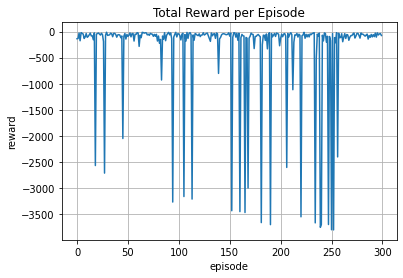

In [216]:
total_reward_per_episode(reward_historyt3)

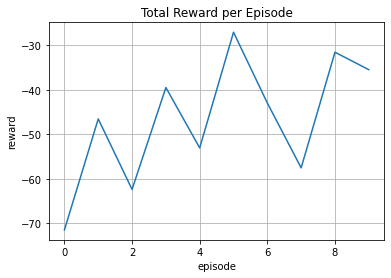

In [217]:
# set-up
episodes = 10
reward_historye3 = list()
max_timesteps = 20

# evaluation
for episode in range(episodes):
    state = environment3.reset()[0]
    total_reward = 0
    step_count = 0

    while step_count <= max_timesteps:
        
        action = agent3.step(state, False)
        next_state, reward, terminated, truncated, info = environment3.step(tf.squeeze(action))
        
        # environment rendered on google colab
        #environment3.render()
        
        total_reward += reward
        step_count+=1

        if terminated: break
        
        state = next_state
    reward_historye3.append(total_reward)

total_reward_per_episode(reward_historye3)

In [218]:
# save the model in .h5 format
agent2.model.save_weights("likhitsa_assignment3_part2_mujoco_ant.h5")